In [158]:
import tensorflow_federated as tff
import collections
import os
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Dense, InputLayer, Softmax
from tensorflow.keras.models import Sequential
import pickle
from joblib import dump,load 
from sklearn.model_selection import train_test_split,KFold
from sklearn.metrics import roc_curve, confusion_matrix,accuracy_score,auc, classification_report
from sklearn.decomposition import PCA,KernelPCA
from itertools import cycle
import seaborn as sns
import tensorflow_privacy as tfp



FIGURESIZE=(15,10)
FONTSIZE=18
plt.rcParams['figure.figsize'] = FIGURESIZE
plt.rcParams['font.size'] = FONTSIZE
plt.rcParams['xtick.labelsize'] = FONTSIZE
plt.rcParams['ytick.labelsize'] = FONTSIZE

### Data Visualization

In [170]:
# with open('/home/harinadh_asr2/project/WESAD/S3_train_data.npy', 'rb') as f:
# data = np.load('/home/harinadh_asr2/project/WESAD/S2_train_data.npy',allow_pickle=True)
with open('/home/harinadh_asr2/project/WESAD/S2/S2.pkl', 'rb') as f:
    data = pickle.load(f, encoding='latin1')

In [171]:
# data = data.item()

In [172]:
# plt.hist(data.item().get('features')[:,1])

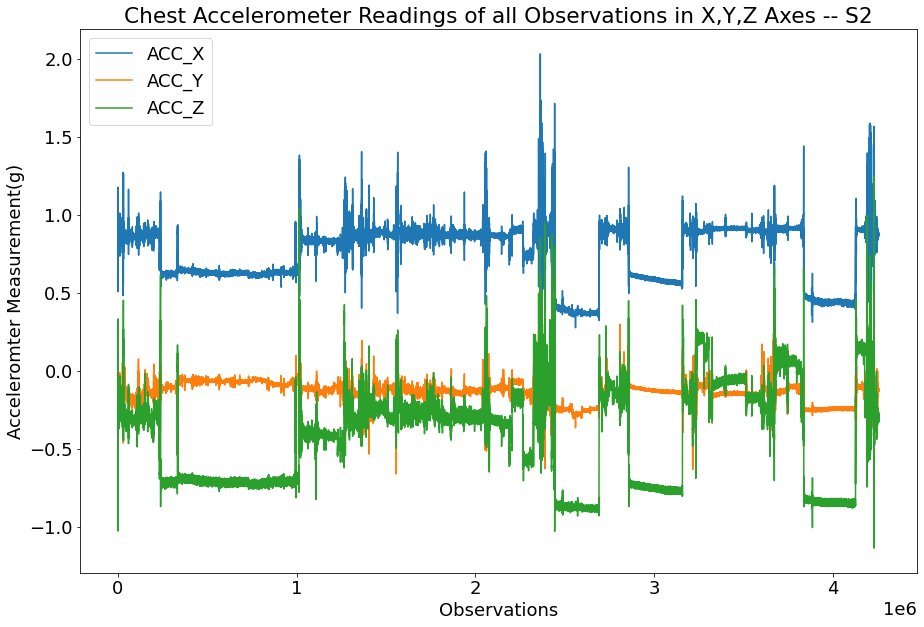

In [186]:
acc = data.get('signal',{}).get('chest',{}).get('ACC',np.array([]))

plt.plot(data['signal']['chest']['ACC'])
plt.ylabel('Acceleromter Measurement(g)')
plt.xlabel('Observations')
plt.title('Chest Accelerometer Readings of all Observations in X,Y,Z Axes -- S2')
plt.legend(['ACC_X','ACC_Y','ACC_Z'])
plt.savefig('chest_acc.png')

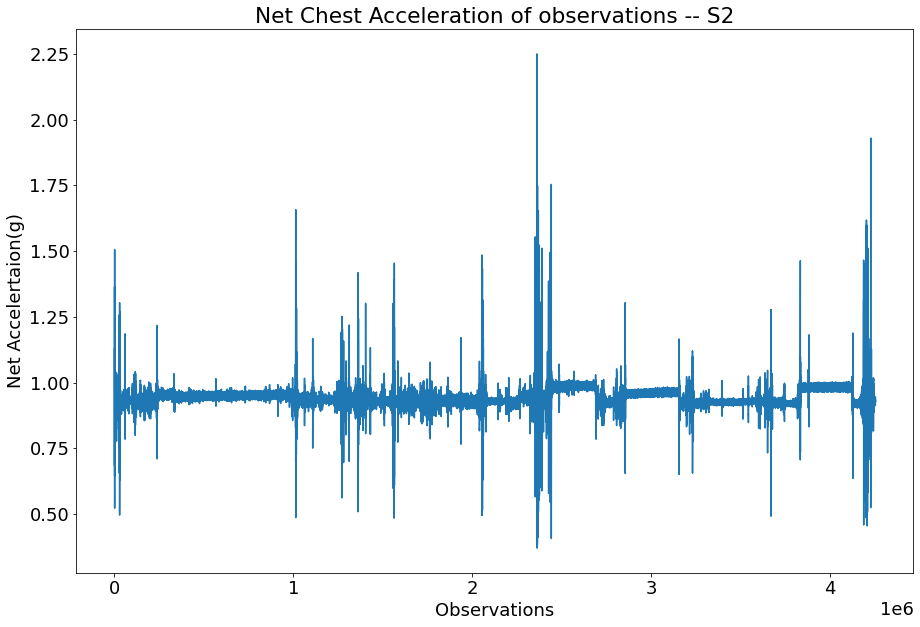

In [190]:
plt.plot(np.sqrt(acc[:,0]**2+acc[:,1]**2+acc[:,2]**2))
plt.ylabel('Net Accelertaion(g)')
plt.xlabel('Observations') 
plt.title('Net Chest Acceleration of observations -- S2')
plt.savefig('chest_net_acc.png')

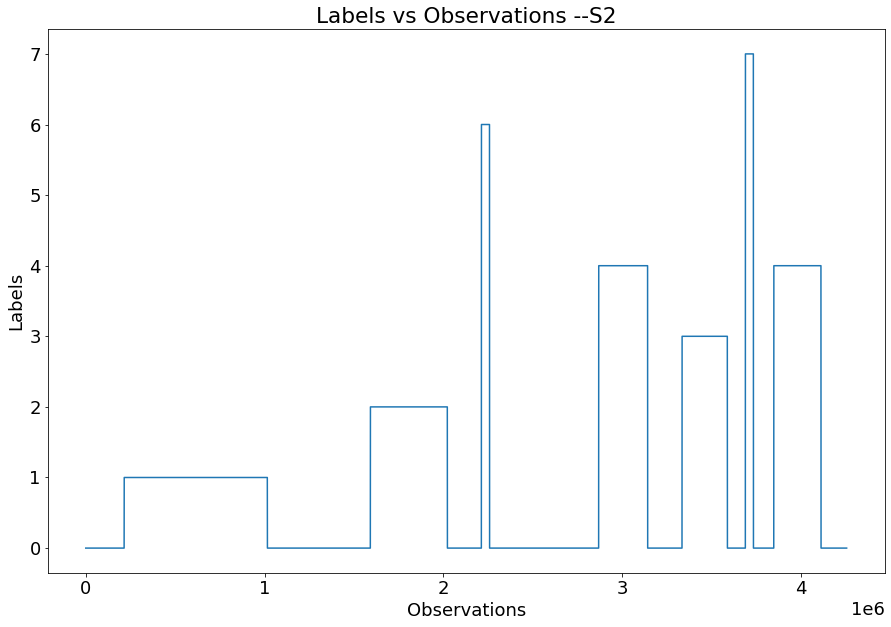

In [191]:
plt.plot(data['label'])
plt.ylabel('Labels')
plt.xlabel('Observations') 
plt.title('Labels vs Observations --S2')
plt.savefig('labels.png')

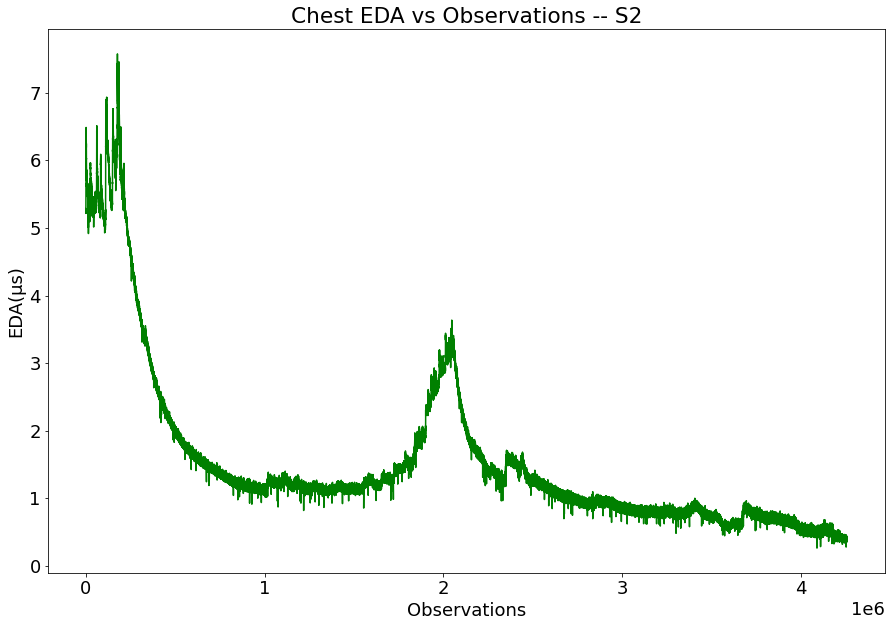

In [192]:
plt.plot(data['signal']['chest']['EDA'],"g")

plt.ylabel('EDA(μs)')
plt.xlabel('Observations') 
plt.title('Chest EDA vs Observations -- S2')
plt.savefig('chest_eda.png')

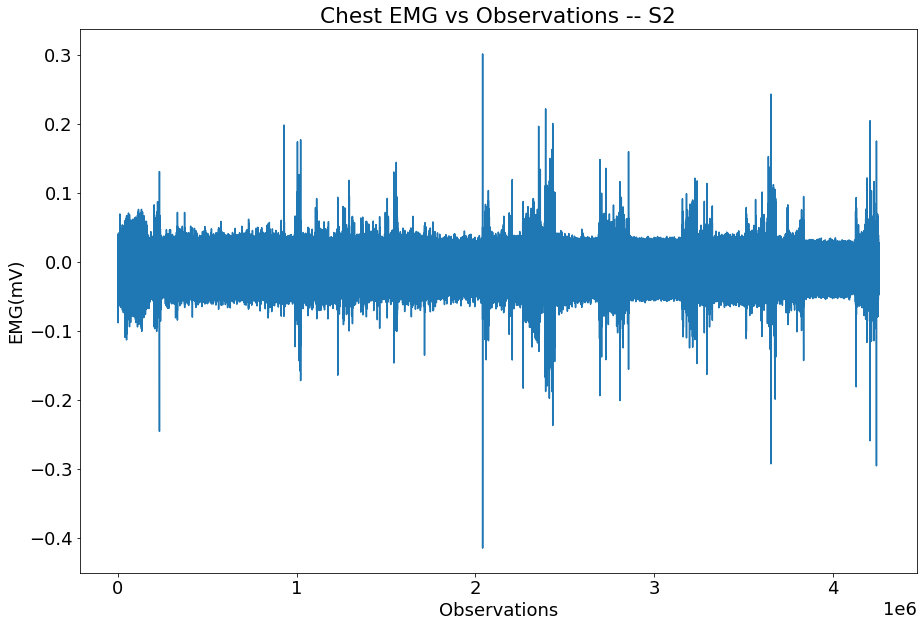

In [194]:
plt.plot(data['signal']['chest']['EMG'])

plt.ylabel('EMG(mV)')
plt.xlabel('Observations') 
plt.title('Chest EMG vs Observations -- S2')
plt.savefig('chest_EMG.png')

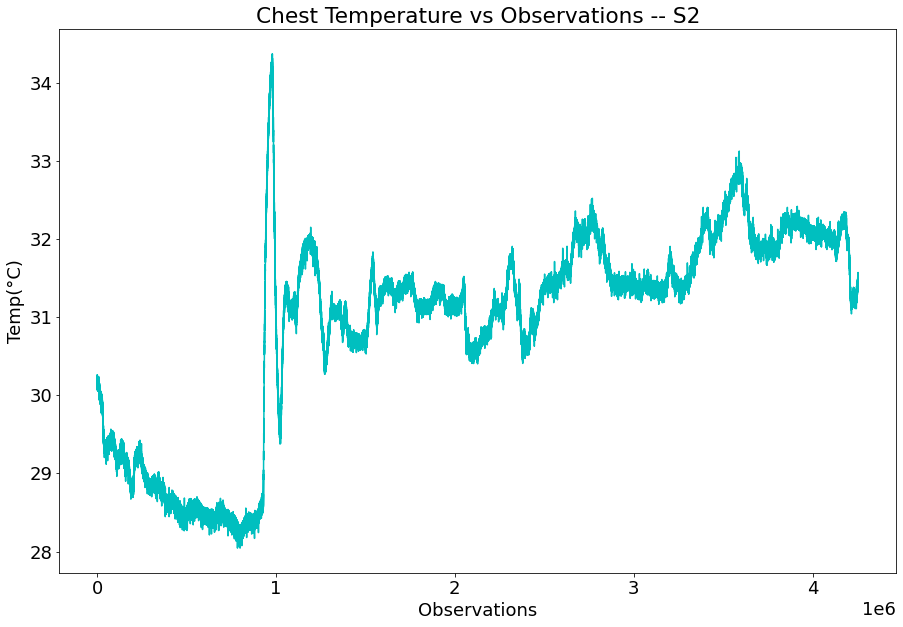

In [198]:
plt.plot(data['signal']['chest']['Temp'],"c")

plt.ylabel('Temp(°C)')
plt.xlabel('Observations') 
plt.title('Chest Temperature vs Observations -- S2')
plt.savefig('chest_Temp.png')

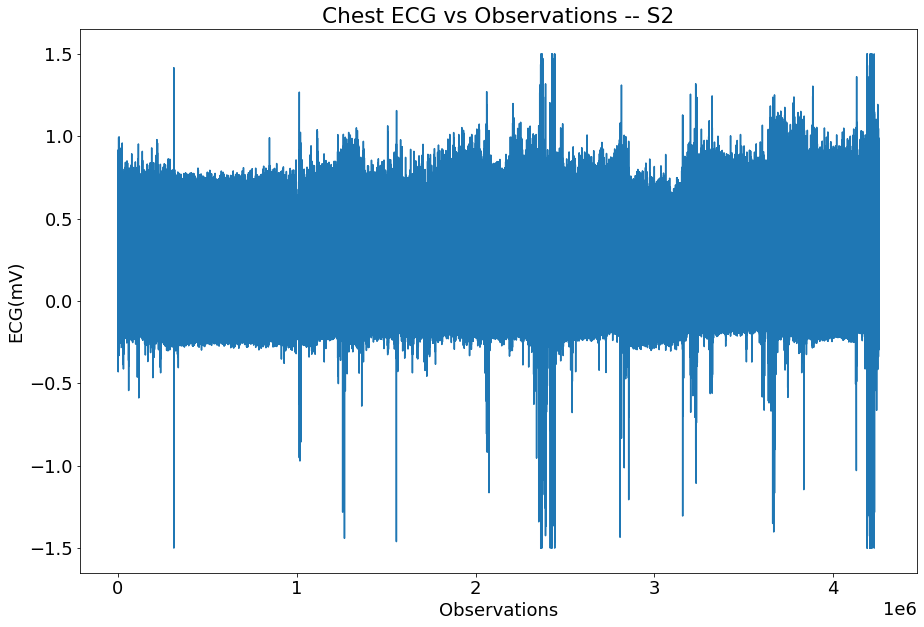

In [199]:
plt.plot(data['signal']['chest']['ECG'])
plt.ylabel('ECG(mV)')
plt.xlabel('Observations') 
plt.title('Chest ECG vs Observations -- S2')
plt.savefig('chest_ECG.png')

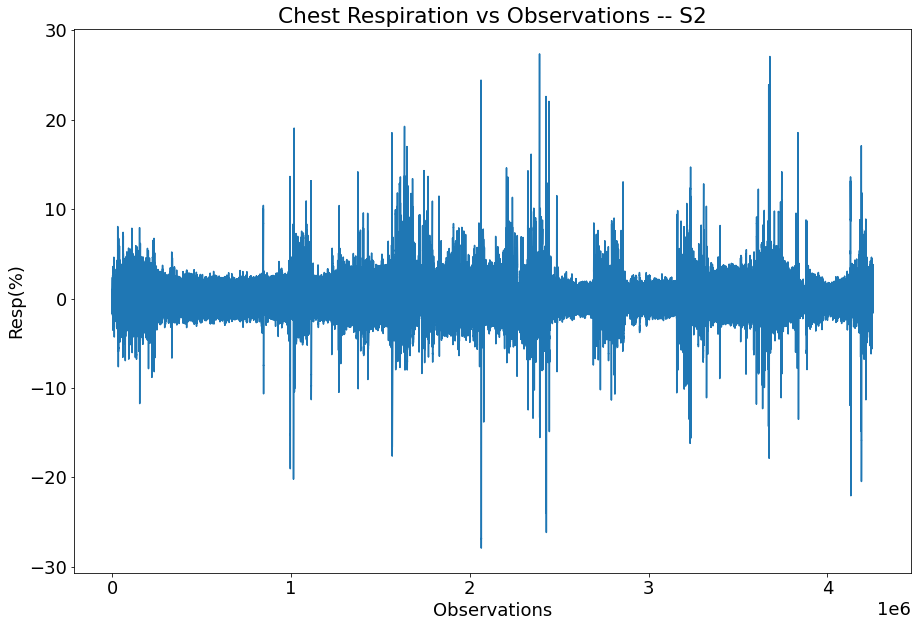

In [200]:
plt.plot(data['signal']['chest']['Resp'])
plt.ylabel('Resp(%)')
plt.xlabel('Observations') 
plt.title('Chest Respiration vs Observations -- S2')
plt.savefig('chest_Resp.png')

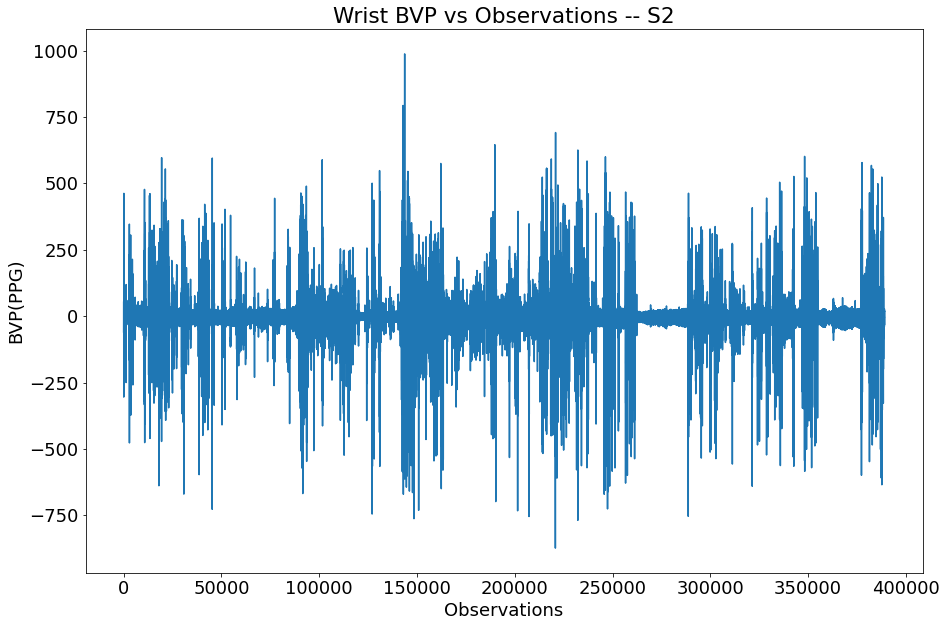

In [202]:
plt.plot(data['signal']['wrist']['BVP'])
plt.ylabel('BVP(PPG)')
plt.xlabel('Observations') 
plt.title('Wrist BVP vs Observations -- S2')
plt.savefig('wrist_BVP.png')

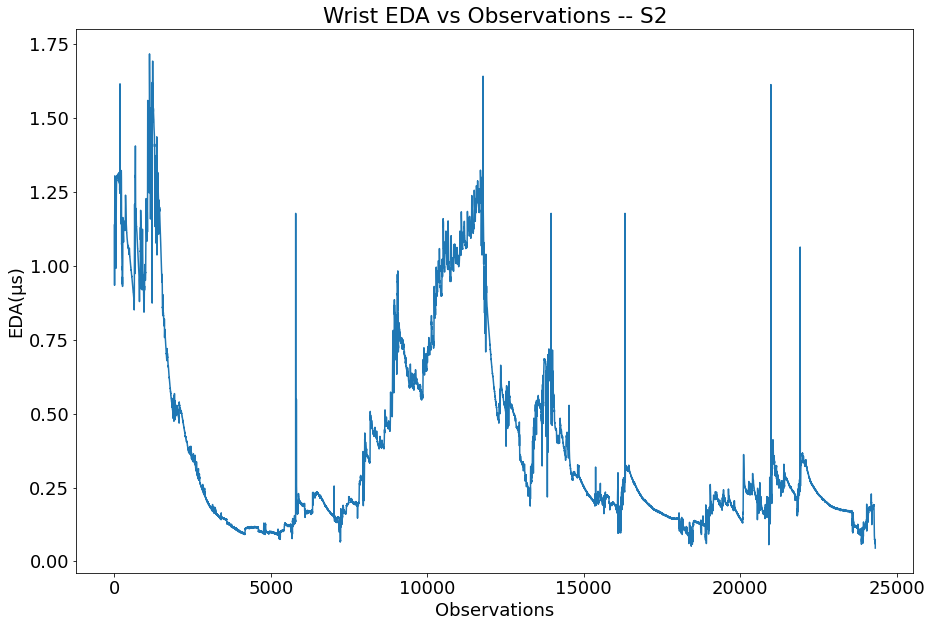

In [203]:
plt.plot(data['signal']['wrist']['EDA'])
plt.ylabel('EDA(μs)')
plt.xlabel('Observations') 
plt.title('Wrist EDA vs Observations -- S2')
plt.savefig('wrist_EDA.png')

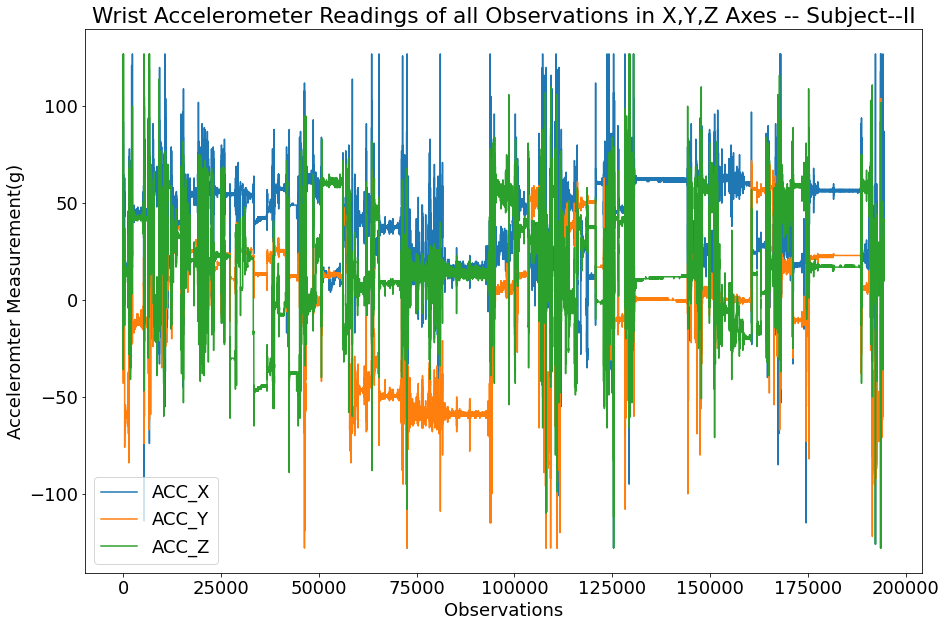

In [204]:
acc = data.get('signal',{}).get('wrist',{}).get('ACC',np.array([]))

plt.plot(data['signal']['wrist']['ACC'])
plt.ylabel('Acceleromter Measurement(g)')
plt.xlabel('Observations')
plt.title('Wrist Accelerometer Readings of all Observations in X,Y,Z Axes -- Subject--II')
plt.legend(['ACC_X','ACC_Y','ACC_Z'])
plt.savefig('wrist_ACC.png')

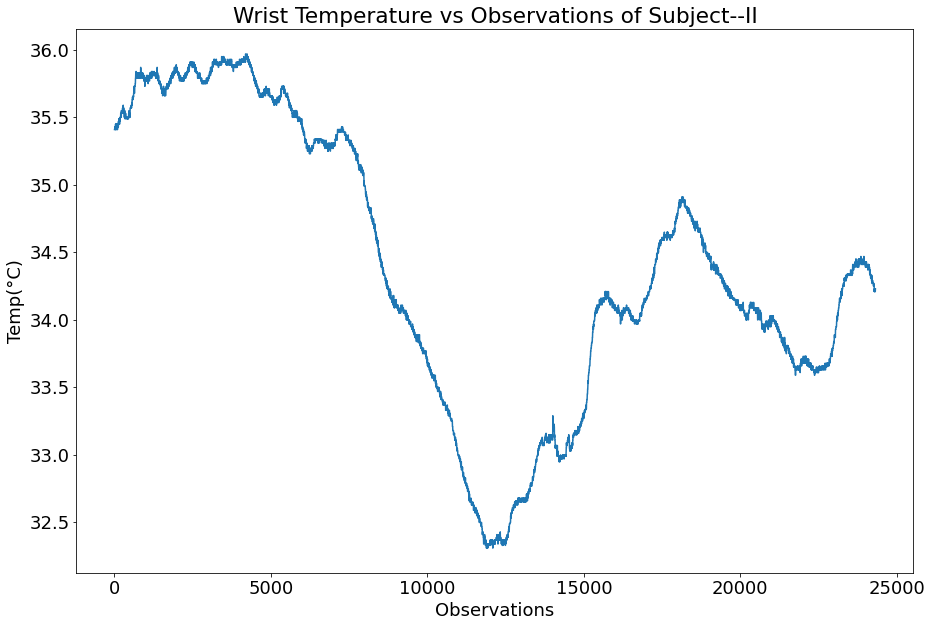

In [205]:
plt.plot(data['signal']['wrist']['TEMP'])
plt.ylabel('Temp(°C)')
plt.xlabel('Observations') 
plt.title('Wrist Temperature vs Observations of Subject--II')
plt.savefig('wrist_Temp.png')

### Principal Component Analysis

In [159]:
pca = PCA(n_components=8)
pca.fit(features)

PCA(n_components=8)

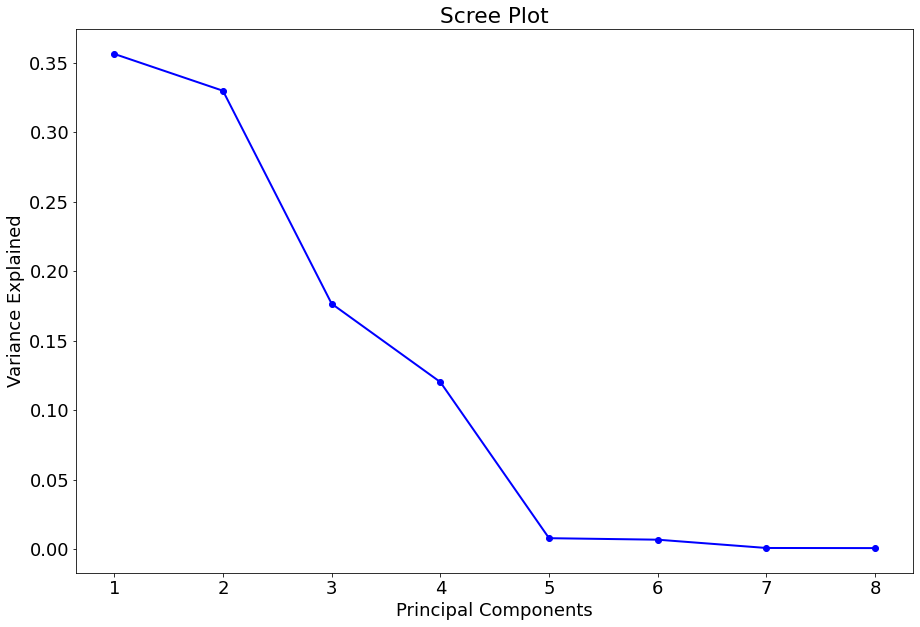

In [162]:
PC_values = np.arange(pca.n_components_) + 1
plt.plot(PC_values, pca.explained_variance_ratio_, 'o-', linewidth=2, color='blue')
plt.title('Scree Plot')
plt.xlabel('Principal Components')
plt.ylabel('Variance Explained')
plt.show()

In [164]:
features = pca.transform(features)

###  Centralized Training on All Data

In [50]:
model = tf.keras.models.Sequential([
      tf.keras.layers.InputLayer(input_shape=(56,)),
#       tf.keras.layers.Dense(15,) ,
#                             kernel_initializer='glorot_uniform',activation='relu',kernel_regularizer=tf.keras.regularizers.L2(1e-4)),
      tf.keras.layers.Dense(20,),
#                             kernel_regularizer=tf.keras.regularizers.L2(1e-4)),
      tf.keras.layers.Dense(10,kernel_initializer='glorot_uniform'),
#                             activation='relu',kernel_regularizer=tf.keras.regularizers.L2(1e-4)),
      tf.keras.layers.Dense(3, use_bias=True, name="output", activation='softmax')
  ])

opt =  tf.keras.optimizers.Adam(learning_rate=0.00001, beta_1=0.9, beta_2=0.999, epsilon= None, decay=0.0, amsgrad= False)
model.compile(optimizer=opt, loss='sparse_categorical_crossentropy', metrics='sparse_categorical_accuracy')

In [51]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 20)                1140      
                                                                 
 dense_3 (Dense)             (None, 10)                210       
                                                                 
 output (Dense)              (None, 3)                 33        
                                                                 
Total params: 1,383
Trainable params: 1,383
Non-trainable params: 0
_________________________________________________________________


In [83]:
DATASET_PATH = "../WESAD/"
# federated_data = collections.OrderedDict()
train_dataset_dict = collections.OrderedDict()
test_dataset_dict = collections.OrderedDict()
X_train, X_test, y_train, y_test = [],[],[],[]

for root, dirnames, filenames in os.walk(DATASET_PATH, topdown=True):
    for file_name in filenames :
        
        if file_name.endswith('.npy'):
            subject_no = file_name.split('_')[0]
            file_path = os.path.join(root,file_name)

            if os.path.exists(file_path):           
                data = np.load(file_path, allow_pickle=True)
                
                if file_name.endswith('train_data.npy'):
                    X_train +=[data.item().get('features')]
                    y_train +=[data.item().get('labels')]
                    print(f'Number of examples in subject {subject_no} for train: ',data.item().get('features').shape[0])
#                     train_dataset_dict[subject_no] = collections.OrderedDict((('features', data.item().get('features')),('labels',data.item().get('labels'))))
                elif file_name.endswith('test_data.npy'):
                    X_test += [data.item().get('features')]
                    y_test += [data.item().get('labels')]
                    print(f'Number of examples in subject {subject_no}: for test ',data.item().get('features').shape[0])
#                     test_dataset_dict[subject_no] = collections.OrderedDict((('features', data.item().get('features')),('labels',data.item().get('labels'))))

Number of examples in subject S14: for test  671
Number of examples in subject S17: for test  686
Number of examples in subject S15: for test  673
Number of examples in subject S3: for test  649
Number of examples in subject S16 for train:  1561
Number of examples in subject S10 for train:  1598
Number of examples in subject S6: for test  664
Number of examples in subject S2: for test  639
Number of examples in subject S2 for train:  1491
Number of examples in subject S9 for train:  1543
Number of examples in subject S4: for test  653
Number of examples in subject S8 for train:  1554
Number of examples in subject S6 for train:  1548
Number of examples in subject S9: for test  662
Number of examples in subject S4 for train:  1521
Number of examples in subject S7 for train:  1545
Number of examples in subject S7: for test  663
Number of examples in subject S13: for test  669
Number of examples in subject S13 for train:  1559
Number of examples in subject S11: for test  672
Number of exam

In [84]:
X_train,y_train = np.vstack(X_train), np.concatenate(y_train)
X_test,y_test = np.vstack(X_test), np.concatenate(y_test)
y_train = y_train-1
y_test = y_test-1

In [87]:
np.unique(y_valid)

array([0., 1., 2.])

In [153]:
from sklearn.preprocessing import label_binarize
# Binarize the output
y_test = label_binarize(y_test, classes=[0, 1, 2])
n_classes = y_test.shape[1]

In [86]:
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.3, random_state=42, stratify=y_train)

In [207]:
~len(X_train)

-1098

In [62]:
# data = np.load('/home/harinadh_asr2/project/WESAD/S11_train_data.npy', allow_pickle=True)
# X_train, X_valid, y_train,y_valid = train_test_split(data.item()['features'], data.item()['labels'],test_size=0.3, random_state=42)                                     

In [80]:
# y_train = y_train-1
# y_valid = y_valid-1

In [88]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=0.001,
    patience=5,
    verbose=0,
    mode="auto",
    baseline=None,
    restore_best_weights=True,
)

In [66]:
history = model.fit(
    x=X_train,
    y=y_train,
    batch_size=8,
    epochs=50,
    verbose="auto",
    callbacks=[early_stopping],
    validation_split=0.0,
    validation_data=(X_valid,y_valid),
    shuffle=True,
    class_weight=None,
    sample_weight=None,
    initial_epoch=0,
    steps_per_epoch=None,
    validation_steps=None,
    validation_batch_size=None,
    validation_freq=1,
    max_queue_size=10,
    workers=1,
    use_multiprocessing=False,
)

Epoch 1/50
137/137 [==============================] - 1s 3ms/step - loss: 1.8562 - sparse_categorical_accuracy: 0.2856 - val_loss: 1.8125 - val_sparse_categorical_accuracy: 0.3085
Epoch 2/50
137/137 [==============================] - 0s 2ms/step - loss: 1.7356 - sparse_categorical_accuracy: 0.3075 - val_loss: 1.6970 - val_sparse_categorical_accuracy: 0.3298
Epoch 3/50
137/137 [==============================] - 0s 2ms/step - loss: 1.6218 - sparse_categorical_accuracy: 0.3449 - val_loss: 1.5874 - val_sparse_categorical_accuracy: 0.3553
Epoch 4/50
137/137 [==============================] - 0s 2ms/step - loss: 1.5149 - sparse_categorical_accuracy: 0.3777 - val_loss: 1.4864 - val_sparse_categorical_accuracy: 0.3787
Epoch 5/50
137/137 [==============================] - 0s 2ms/step - loss: 1.4151 - sparse_categorical_accuracy: 0.3969 - val_loss: 1.3916 - val_sparse_categorical_accuracy: 0.4043
Epoch 6/50
137/137 [==============================] - 0s 2ms/step - loss: 1.3220 - sparse_categorica

### Model Evaluation

In [31]:
model.evaluate(X_train, y_train, verbose=0)

[0.23370186984539032, 0.9304762482643127]

In [32]:
model.evaluate(X_test, y_test, verbose=0)

[0.8250695466995239, 0.9292433857917786]

In [61]:
y_preds = np.argmax(model.predict(X_test),axis=-1)

313/313 [==============================] - 0s 1ms/step


In [154]:
 y_preds = label_binarize(y_preds, classes=[0, 1, 2])

### ROC Curve

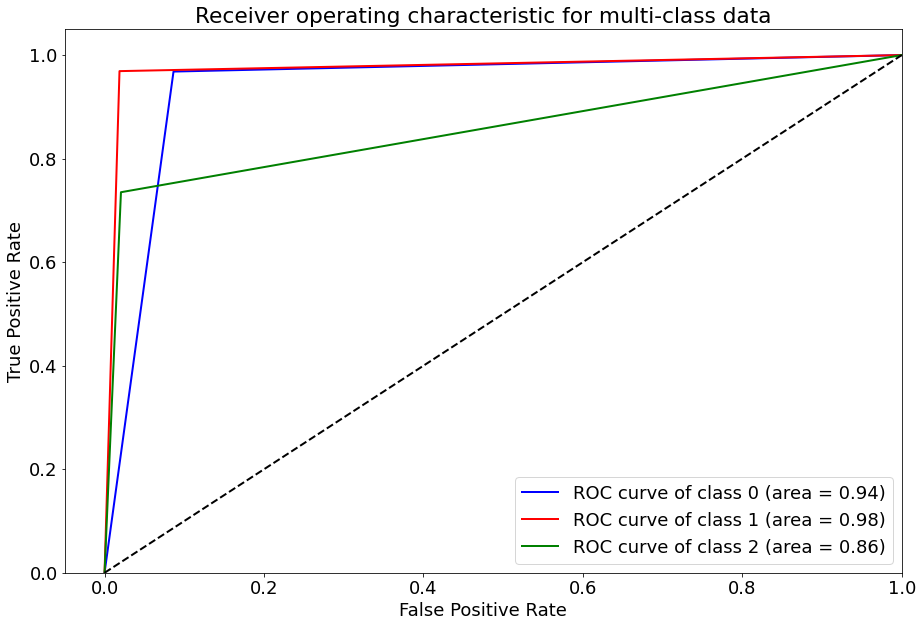

In [48]:
fpr = dict()
tpr = dict()
roc_auc = dict()
lw=2
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_preds[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
colors = cycle(['blue', 'red', 'green'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))
plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic for multi-class data')
plt.legend(loc="lower right")
plt.show()

### Validation Accuracy Curve

Text(0.5, 1.0, 'Validation Set Accuracy vs Epochs')

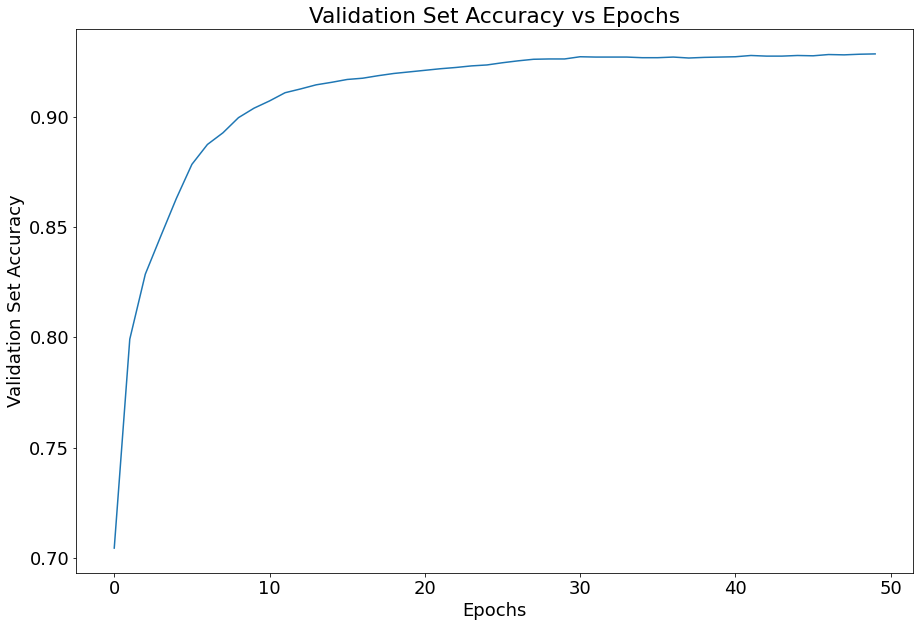

In [50]:
plt.plot(history.history['val_sparse_categorical_accuracy'])
plt.ylabel('Validation Set Accuracy')
plt.xlabel('Epochs')
plt.title('Validation Set Accuracy vs Epochs')

### Validation Loss Curve

Text(0.5, 1.0, 'Loss vs Epochs')

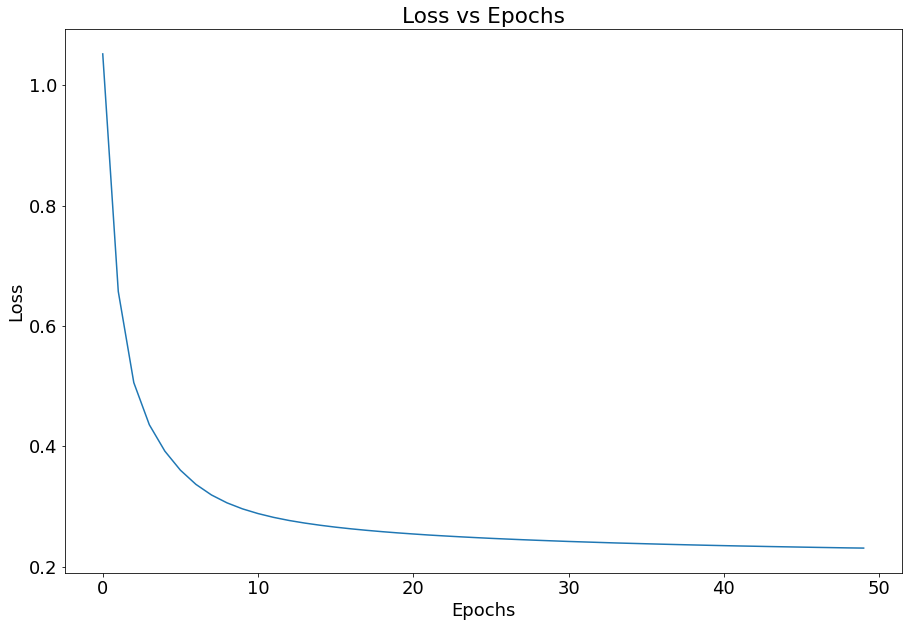

In [51]:
plt.plot(history.history['loss'])
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.title('Loss vs Epochs')

### Classification Report


In [128]:
target_names = ['Neutral', 'Stress', 'Amusement']
print(metrics.classification_report(y_test, y_preds, target_names=target_names))

              precision    recall  f1-score   support

     Neutral       0.93      0.97      0.95      5310
      Stress       0.96      0.97      0.96      3002
   Amusement       0.88      0.74      0.80      1680

    accuracy                           0.93      9992
   macro avg       0.92      0.89      0.90      9992
weighted avg       0.93      0.93      0.93      9992



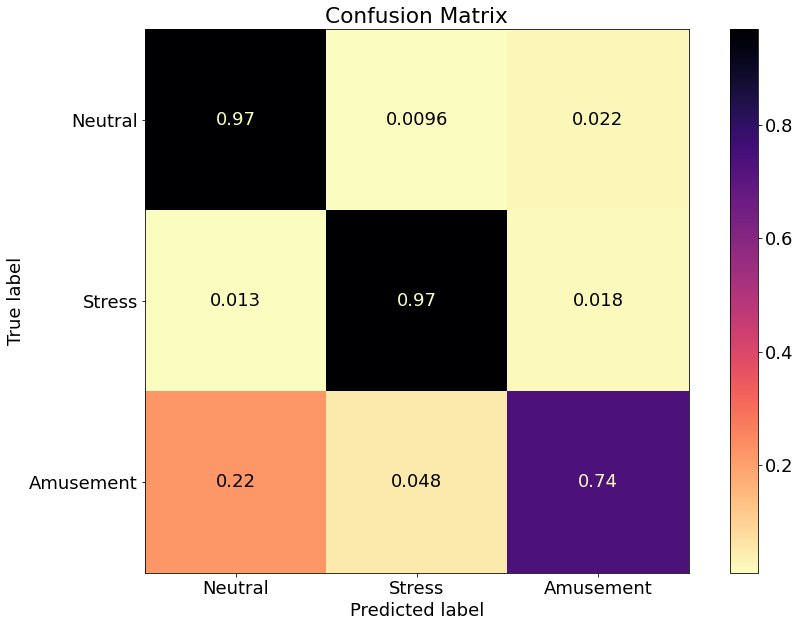

In [137]:
cm = confusion_matrix(y_test, y_preds)
cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
# sns.heatmap(cmn,annot=True, cmap='magma_r')
cmd = metrics.ConfusionMatrixDisplay(cmn, display_labels=['Neutral','Stress','Amusement'])
cmd.plot(cmap='magma_r')

# plt.xlabel('Predicted Class')
# plt.ylabel('True Class')
plt.title('Confusion Matrix')
plt.savefig('confusion_matrix.png',bbox_inches='tight', dpi=150)

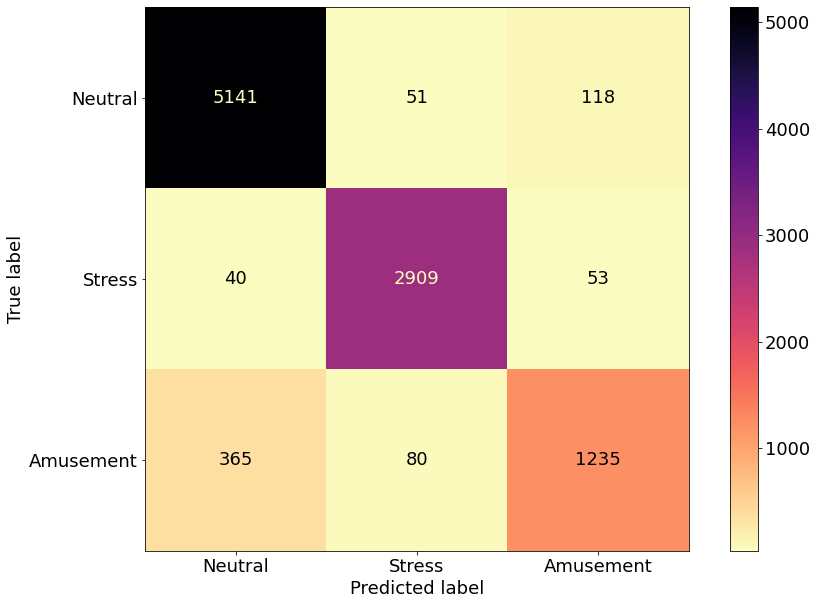

In [136]:
cmd = metrics.ConfusionMatrixDisplay(cm, display_labels=['Neutral','Stress','Amusement'])
cmd.plot(cmap='magma_r')

* Performed Stratified split to sample train and test in same proportion so that labels ratio is same in test and train data
* Performed same step for train and validation split
* Used held out validation for model training

## Federated Training

In [119]:
DATASET_PATH = "../WESAD/"
# federated_data = collections.OrderedDict()
train_dataset_dict = collections.OrderedDict()
test_dataset_dict = collections.OrderedDict()
validation_dataset_dict = collections.OrderedDict()

for root, dirnames, filenames in os.walk(DATASET_PATH, topdown=True):
    for file_name in filenames :
        
        if file_name.endswith('.npy'):
            subject_no = file_name.split('_')[0]
            file_path = os.path.join(root,file_name)

            if os.path.exists(file_path):           
                data = np.load(file_path, allow_pickle=True)
                
                if file_name.endswith('train_data.npy'):
                    print(f'Number of examples in subject {subject_no} for train: ',data.item().get('features').shape[0])
                    X_train, X_valid, y_train,y_valid = train_test_split(data.item()['features'], data.item()['labels'],test_size=0.3, random_state=42)
                    y_train,y_valid = y_train-1, y_valid-1
                    train_dataset_dict[subject_no] = collections.OrderedDict((('features', X_train),('labels',y_train)))
                    validation_dataset_dict[subject_no] = collections.OrderedDict((('features', X_valid),('labels',y_valid)))
                                                                                                 
                elif file_name.endswith('test_data.npy'):
                    print(f'Number of examples in subject {subject_no}: for test ',data.item().get('features').shape[0])
                    test_dataset_dict[subject_no] = collections.OrderedDict((('features', data.item().get('features')),('labels',data.item().get('labels')-1)))

Number of examples in subject S14: for test  671
Number of examples in subject S17: for test  686
Number of examples in subject S15: for test  673
Number of examples in subject S3: for test  649
Number of examples in subject S16 for train:  1561
Number of examples in subject S10 for train:  1598
Number of examples in subject S6: for test  664
Number of examples in subject S2: for test  639
Number of examples in subject S2 for train:  1491
Number of examples in subject S9 for train:  1543
Number of examples in subject S4: for test  653
Number of examples in subject S8 for train:  1554
Number of examples in subject S6 for train:  1548
Number of examples in subject S9: for test  662
Number of examples in subject S4 for train:  1521
Number of examples in subject S7 for train:  1545
Number of examples in subject S7: for test  663
Number of examples in subject S13: for test  669
Number of examples in subject S13 for train:  1559
Number of examples in subject S11: for test  672
Number of exam

In [120]:
tff_dataset_train = tff.simulation.datasets.TestClientData(train_dataset_dict)
tff_dataset_test = tff.simulation.datasets.TestClientData(test_dataset_dict)
tff_dataset_valid = tff.simulation.datasets.TestClientData(validation_dataset_dict)

### Plotting Label Distribution of Training Data

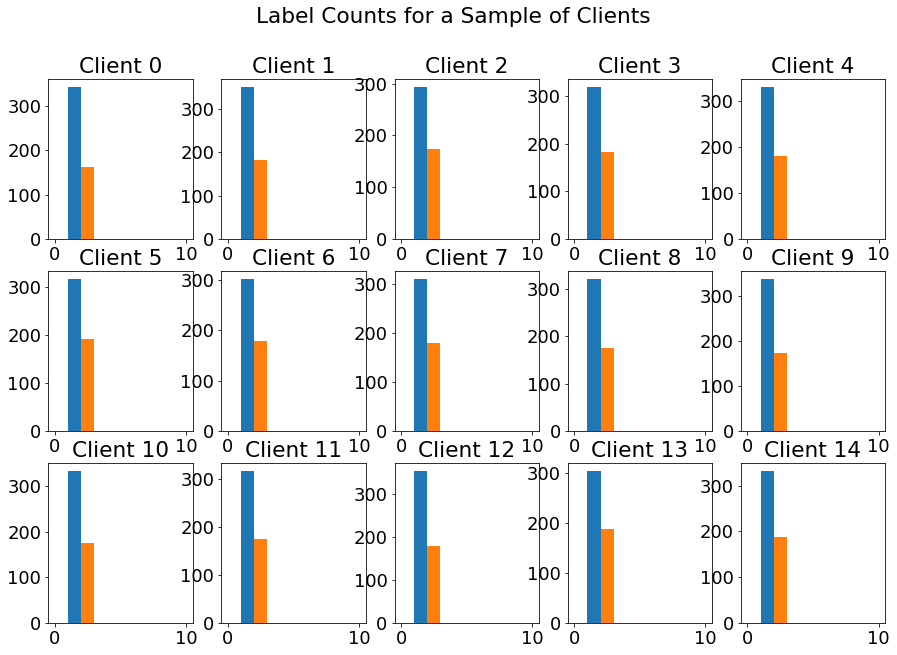

In [121]:
# Number of examples per layer for a sample of clients
f = plt.figure(figsize=(15, 10))
f.suptitle('Label Counts for a Sample of Clients')
for i in range(15):
    client_dataset = tff_dataset_train.create_tf_dataset_for_client(tff_dataset_train.client_ids[i])
    plot_data = collections.defaultdict(list)
    for example in client_dataset:
        # Append counts individually per label to make plots
        # more colorful instead of one color per plot.
        label = example['labels'].numpy()
        plot_data[label].append(label)
    plt.subplot(3, 5, i+1)
    plt.title('Client {}'.format(i))    
    for j in range(1,4):
        plt.hist(
        plot_data[j],
        density=False,
        bins=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10])
# plt.legend(['Neutral','Stress','Amusement'])

* The data from different client is same and not showing Non-IID characteristics.
* For now, lets go with creating a federated model and come back later to simulate real time federate characteristics.

#### Plotting Label Distribution of Validation Data

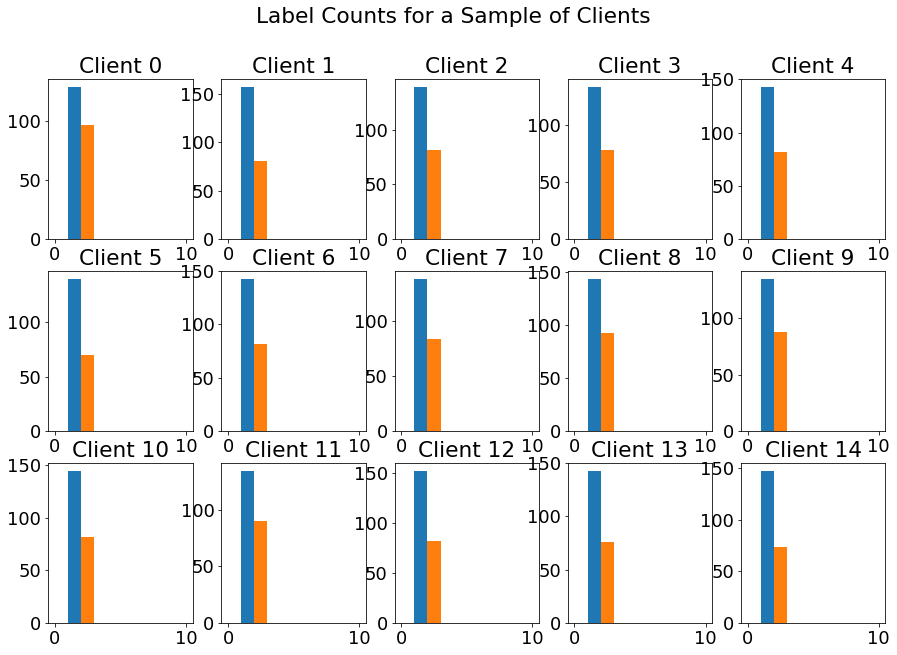

In [122]:
# Number of examples per layer for a sample of clients
f = plt.figure(figsize=(15, 10))
f.suptitle('Label Counts for a Sample of Clients')
for i in range(15):
    client_dataset = tff_dataset_valid.create_tf_dataset_for_client(tff_dataset_valid.client_ids[i])
    plot_data = collections.defaultdict(list)
    for example in client_dataset:
        # Append counts individually per label to make plots
        # more colorful instead of one color per plot.
        label = example['labels'].numpy()
        plot_data[label].append(label)
    plt.subplot(3, 5, i+1)
    plt.title('Client {}'.format(i))    
    for j in range(1,4):
        plt.hist(
        plot_data[j],
        density=False,
        bins=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10])
# plt.legend(['Neutral','Stress','Amusement'])

#### Create a example dataset for one client

In [123]:
example_dataset = tff_dataset_train.create_tf_dataset_for_client(tff_dataset_train.client_ids[0])

### Preprocess Function to perform batching and standardization

In [124]:
NUM_CLIENTS = 15
NUM_EPOCHS = 3
BATCH_SIZE = 16
SHUFFLE_BUFFER = 200
PREFETCH_BUFFER = 10
train_transformation = {}

def preprocess_fn(dataset, train):
    
    def batch_format_fn(element,epsilon=1e-8, train=True):
        """Flatten a batch `features` and return the features as an `OrderedDict`."""
        
        return collections.OrderedDict(
            x=tf.reshape(element['features'], [-1, 56]),
            y=tf.reshape(element['labels'], [-1, 1]))

    return dataset.repeat(NUM_EPOCHS).shuffle(SHUFFLE_BUFFER, seed=1).batch(
          BATCH_SIZE).map(lambda x : batch_format_fn(x,train)).prefetch(PREFETCH_BUFFER)

#### Create an example spec

In [125]:
data = preprocess_fn(example_dataset, train=True)

#### Creating Model to be used on Client Devices

In [126]:
def create_keras_model():

#     return tf.keras.models.Sequential([
#       tf.keras.layers.InputLayer(input_shape=(56,)),
#       tf.keras.layers.Dense(15,kernel_regularizer=tf.keras.regularizers.L1L2(l1=0.01, l2=0.001)),
#       tf.keras.layers.Dense(10, kernel_regularizer=tf.keras.regularizers.L1L2(l1=0.01, l2=0.001)),
#       tf.keras.layers.Softmax()
#   ])

    model = tf.keras.models.Sequential([
          tf.keras.layers.InputLayer(input_shape=(56,)),
    #       tf.keras.layers.Dense(15,) ,
    #                             kernel_initializer='glorot_uniform',activation='relu',kernel_regularizer=tf.keras.regularizers.L2(1e-4)),
          tf.keras.layers.Dense(20,),
    #                             kernel_regularizer=tf.keras.regularizers.L2(1e-4)),
          tf.keras.layers.Dense(10,kernel_initializer='glorot_uniform'),
    #                             activation='relu',kernel_regularizer=tf.keras.regularizers.L2(1e-4)),
          tf.keras.layers.Dense(3, use_bias=True, name="output", activation='softmax')
      ])
    
    return model

### Create a Model Function to wrap client model for TFF context

In [127]:
def model_fn():
  # We _must_ create a new model here, and _not_ capture it from an external
  # scope. TFF will call this within different graph contexts.
    keras_model = create_keras_model()
    return tff.learning.from_keras_model(
      keras_model,
      input_spec=data.element_spec,
      loss=tf.keras.losses.SparseCategoricalCrossentropy(),
      metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])


### Create TFF Federated Averaging Process for Training

In [128]:
federated_training = tff.learning.algorithms.build_weighted_fed_avg(
    model_fn,
    client_optimizer_fn=lambda: tf.keras.optimizers.SGD(learning_rate=0.0001,momentum=0.8),
    server_optimizer_fn=lambda: tf.keras.optimizers.SGD(learning_rate=1)
)

### Create TFF Federated Validation(Evaluation)

In [129]:
federated_validation = tff.learning.build_federated_evaluation(model_fn)

## Initialize Federated Training Process

In [130]:
state = federated_training.initialize()

training_metrics = collections.defaultdict(list)
validation_metrics = collections.defaultdict(list)

NUM_ROUNDS = 100
for round_num in range(2,NUM_ROUNDS):
    
    participating_clients = np.random.choice(tff_dataset_train.client_ids,size=10)
    federated_train_data = [
        preprocess_fn(tff_dataset_train.create_tf_dataset_for_client(c),train=True) for c in participating_clients
      ]
    
    result = federated_training.next(state, federated_train_data)
    metrics = result.metrics
    state = result.state
    print('round {:2d}, metrics={}'.format(round_num, metrics))
    
    training_metrics['loss'].append(metrics.get('client_work', {}).get('train', {}).get('loss'))
    training_metrics['sparse_categorical_accuracy'].append(metrics.get('client_work', {}).get('train', {}).get('sparse_categorical_accuracy'))
    
    
    federated_validation_data = [
        preprocess_fn(tff_dataset_valid.create_tf_dataset_for_client(c), train=False) for c in participating_clients
      ]
        
    model_weights = federated_training.get_model_weights(state)
    eval_result = federated_validation(model_weights, federated_validation_data)
    
    validation_metrics['loss'].append(eval_result.get('eval', {}).get('loss'))
    validation_metrics['sparse_categorical_accuracy'].append(eval_result.get('eval', {}).get('sparse_categorical_accuracy'))
    
    print('round {:2d}, evaluation metrics={}'.format(round_num, eval_result))
    print("\n")    

round  2, metrics=OrderedDict([('distributor', ()), ('client_work', OrderedDict([('train', OrderedDict([('sparse_categorical_accuracy', 0.3847539), ('loss', 1.3564869), ('num_examples', 32205), ('num_batches', 2017)]))])), ('aggregator', OrderedDict([('mean_value', ()), ('mean_weight', ())])), ('finalizer', ())])
round  2, evaluation metrics=OrderedDict([('eval', OrderedDict([('sparse_categorical_accuracy', 0.32240555), ('loss', 1.3579257), ('num_examples', 13818), ('num_batches', 867)]))])


round  3, metrics=OrderedDict([('distributor', ()), ('client_work', OrderedDict([('train', OrderedDict([('sparse_categorical_accuracy', 0.57857054), ('loss', 0.9328754), ('num_examples', 32544), ('num_batches', 2039)]))])), ('aggregator', OrderedDict([('mean_value', ()), ('mean_weight', ())])), ('finalizer', ())])
round  3, evaluation metrics=OrderedDict([('eval', OrderedDict([('sparse_categorical_accuracy', 0.4799227), ('loss', 1.0464474), ('num_examples', 13971), ('num_batches', 876)]))])


roun

round 18, evaluation metrics=OrderedDict([('eval', OrderedDict([('sparse_categorical_accuracy', 0.8584622), ('loss', 0.40035105), ('num_examples', 13968), ('num_batches', 877)]))])


round 19, metrics=OrderedDict([('distributor', ()), ('client_work', OrderedDict([('train', OrderedDict([('sparse_categorical_accuracy', 0.93068576), ('loss', 0.3091175), ('num_examples', 32634), ('num_batches', 2044)]))])), ('aggregator', OrderedDict([('mean_value', ()), ('mean_weight', ())])), ('finalizer', ())])
round 19, evaluation metrics=OrderedDict([('eval', OrderedDict([('sparse_categorical_accuracy', 0.90963596), ('loss', 0.35819462), ('num_examples', 14010), ('num_batches', 878)]))])


round 20, metrics=OrderedDict([('distributor', ()), ('client_work', OrderedDict([('train', OrderedDict([('sparse_categorical_accuracy', 0.8816474), ('loss', 0.30229828), ('num_examples', 32682), ('num_batches', 2046)]))])), ('aggregator', OrderedDict([('mean_value', ()), ('mean_weight', ())])), ('finalizer', ())])
r

round 35, evaluation metrics=OrderedDict([('eval', OrderedDict([('sparse_categorical_accuracy', 0.900556), ('loss', 0.28936714), ('num_examples', 14028), ('num_batches', 881)]))])


round 36, metrics=OrderedDict([('distributor', ()), ('client_work', OrderedDict([('train', OrderedDict([('sparse_categorical_accuracy', 0.92071956), ('loss', 0.23696236), ('num_examples', 32631), ('num_batches', 2044)]))])), ('aggregator', OrderedDict([('mean_value', ()), ('mean_weight', ())])), ('finalizer', ())])
round 36, evaluation metrics=OrderedDict([('eval', OrderedDict([('sparse_categorical_accuracy', 0.89395887), ('loss', 0.29875368), ('num_examples', 14004), ('num_batches', 880)]))])


round 37, metrics=OrderedDict([('distributor', ()), ('client_work', OrderedDict([('train', OrderedDict([('sparse_categorical_accuracy', 0.9418615), ('loss', 0.21654685), ('num_examples', 32457), ('num_batches', 2034)]))])), ('aggregator', OrderedDict([('mean_value', ()), ('mean_weight', ())])), ('finalizer', ())])
r

round 52, evaluation metrics=OrderedDict([('eval', OrderedDict([('sparse_categorical_accuracy', 0.8986587), ('loss', 0.27644122), ('num_examples', 14091), ('num_batches', 884)]))])


round 53, metrics=OrderedDict([('distributor', ()), ('client_work', OrderedDict([('train', OrderedDict([('sparse_categorical_accuracy', 0.93975866), ('loss', 0.21459275), ('num_examples', 32652), ('num_batches', 2045)]))])), ('aggregator', OrderedDict([('mean_value', ()), ('mean_weight', ())])), ('finalizer', ())])
round 53, evaluation metrics=OrderedDict([('eval', OrderedDict([('sparse_categorical_accuracy', 0.90216225), ('loss', 0.27862126), ('num_examples', 14013), ('num_batches', 880)]))])


round 54, metrics=OrderedDict([('distributor', ()), ('client_work', OrderedDict([('train', OrderedDict([('sparse_categorical_accuracy', 0.92428595), ('loss', 0.24506137), ('num_examples', 32385), ('num_batches', 2029)]))])), ('aggregator', OrderedDict([('mean_value', ()), ('mean_weight', ())])), ('finalizer', ())])

round 69, evaluation metrics=OrderedDict([('eval', OrderedDict([('sparse_categorical_accuracy', 0.9170062), ('loss', 0.23743412), ('num_examples', 13989), ('num_batches', 878)]))])


round 70, metrics=OrderedDict([('distributor', ()), ('client_work', OrderedDict([('train', OrderedDict([('sparse_categorical_accuracy', 0.9359138), ('loss', 0.1810886), ('num_examples', 32862), ('num_batches', 2058)]))])), ('aggregator', OrderedDict([('mean_value', ()), ('mean_weight', ())])), ('finalizer', ())])
round 70, evaluation metrics=OrderedDict([('eval', OrderedDict([('sparse_categorical_accuracy', 0.907234), ('loss', 0.23358451), ('num_examples', 14100), ('num_batches', 885)]))])


round 71, metrics=OrderedDict([('distributor', ()), ('client_work', OrderedDict([('train', OrderedDict([('sparse_categorical_accuracy', 0.93155974), ('loss', 0.22881016), ('num_examples', 32364), ('num_batches', 2027)]))])), ('aggregator', OrderedDict([('mean_value', ()), ('mean_weight', ())])), ('finalizer', ())])
rou

round 86, evaluation metrics=OrderedDict([('eval', OrderedDict([('sparse_categorical_accuracy', 0.92022544), ('loss', 0.21367687), ('num_examples', 13839), ('num_batches', 870)]))])


round 87, metrics=OrderedDict([('distributor', ()), ('client_work', OrderedDict([('train', OrderedDict([('sparse_categorical_accuracy', 0.9477975), ('loss', 0.19407484), ('num_examples', 32508), ('num_batches', 2036)]))])), ('aggregator', OrderedDict([('mean_value', ()), ('mean_weight', ())])), ('finalizer', ())])
round 87, evaluation metrics=OrderedDict([('eval', OrderedDict([('sparse_categorical_accuracy', 0.91184694), ('loss', 0.25173128), ('num_examples', 13953), ('num_batches', 876)]))])


round 88, metrics=OrderedDict([('distributor', ()), ('client_work', OrderedDict([('train', OrderedDict([('sparse_categorical_accuracy', 0.9112785), ('loss', 0.21986534), ('num_examples', 32664), ('num_batches', 2046)]))])), ('aggregator', OrderedDict([('mean_value', ()), ('mean_weight', ())])), ('finalizer', ())])


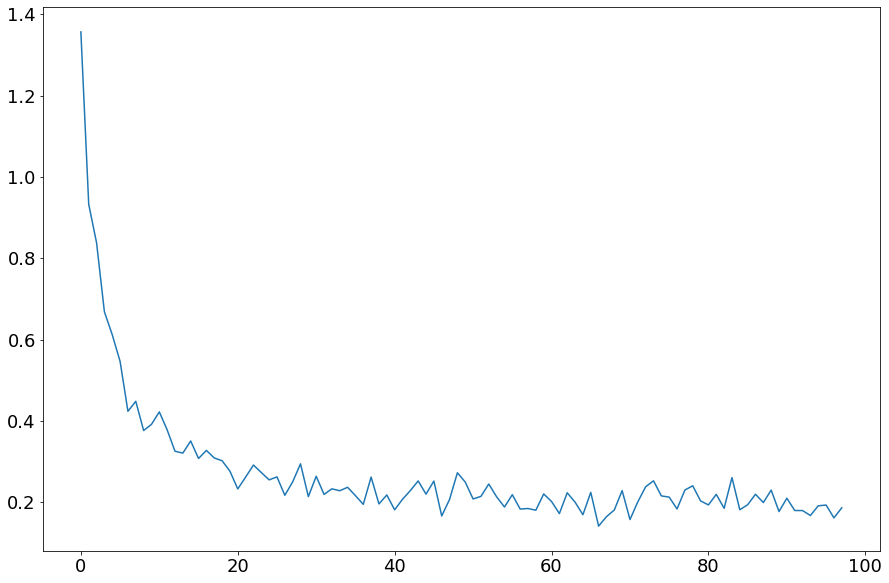

In [131]:
plt.plot(training_metrics['loss'])

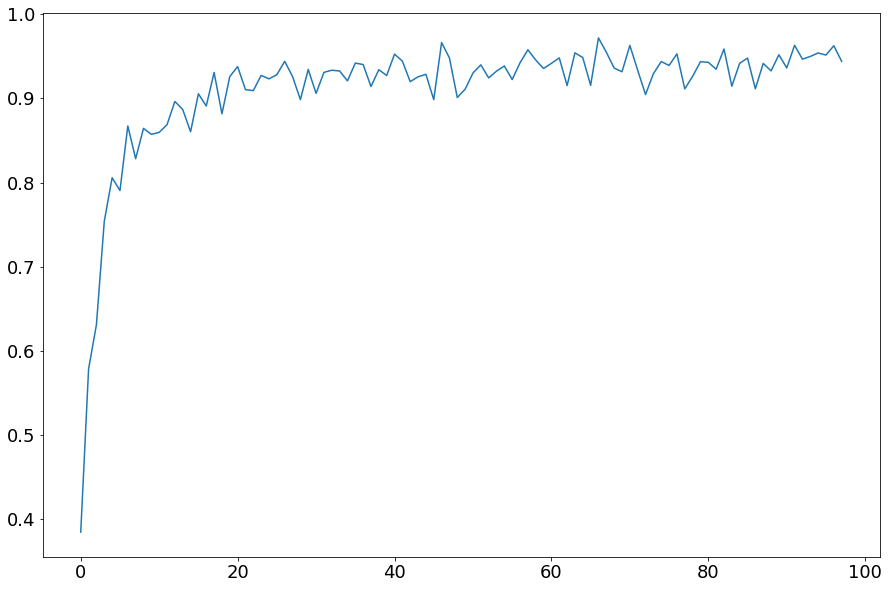

In [132]:
plt.plot(training_metrics['sparse_categorical_accuracy'])

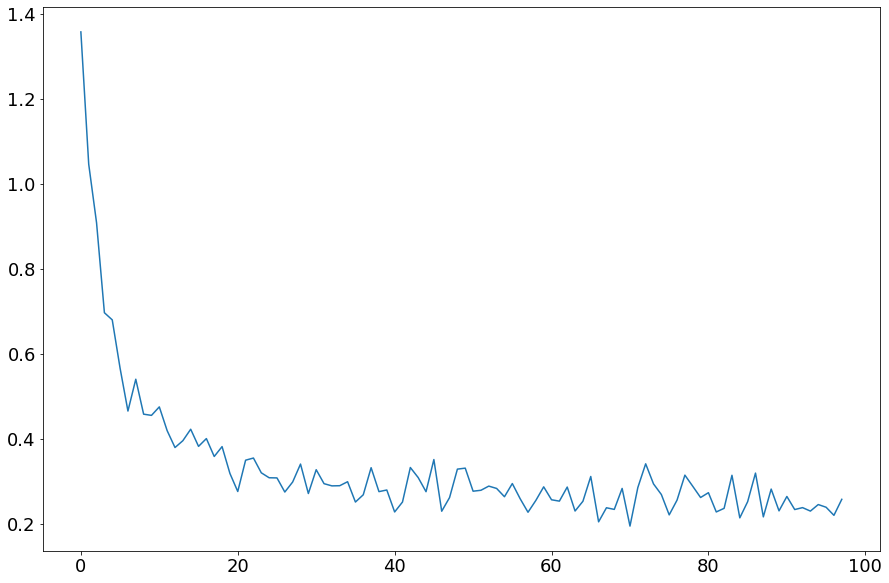

In [133]:
plt.plot(validation_metrics['loss'])

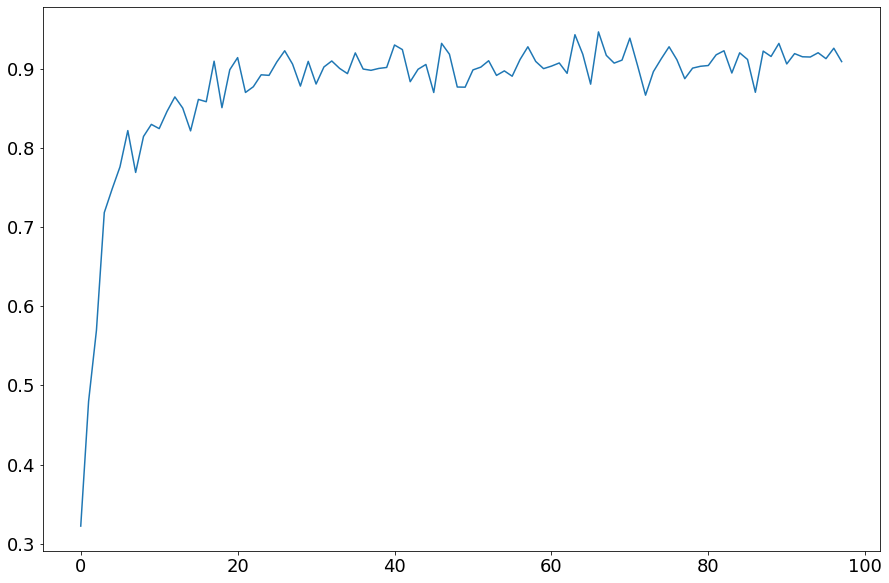

In [134]:
plt.plot(validation_metrics['sparse_categorical_accuracy'])

## Create a Federated Evaluation

In [136]:
federated_evaluation_test = tff.learning.build_federated_evaluation(model_fn)

In [137]:
model_weights = federated_training.get_model_weights(state)
federated_test_data = [
        preprocess_fn(tff_dataset_test.create_tf_dataset_for_client(c), train=False) for c in tff_dataset_test.client_ids
      ]
federated_evaluation_test(model_weights,federated_test_data)

OrderedDict([('eval',
              OrderedDict([('sparse_categorical_accuracy', 0.91883504),
                           ('loss', 0.24872129),
                           ('num_examples', 29976),
                           ('num_batches', 1880)]))])

In [138]:
keras_model = create_keras_model()
model_weights = federated_training.get_model_weights(state)


In [139]:
# keras_model.set_weights(model_weights)

In [140]:
model_weights.assign_weights_to(keras_model)

In [150]:
y_preds = np.argmax(keras_model.predict(X_test), axis=-1)

313/313 [==============================] - 0s 897us/step


In [89]:
X_test

array([[ 0.28860739,  1.06468202,  0.38534691, ...,  1.69496242,
        -0.96559387,  1.67868282],
       [-0.90556256, -0.15093122, -0.83836947, ..., -0.50669183,
        -0.20708618, -0.50324924],
       [-0.81370374, -1.05635121, -0.81323964, ..., -0.29947731,
         2.06843689, -0.28958824],
       ...,
       [-0.44510397, -1.11021939, -0.63292832, ...,  0.91466111,
         0.51210346,  0.92131781],
       [-0.45072589, -1.20752728, -0.62010232, ...,  0.94908175,
        -0.98237311,  0.93854233],
       [ 0.31950061, -1.20296611,  0.07325053, ...,  0.91466111,
        -0.98237311,  0.90409329]])

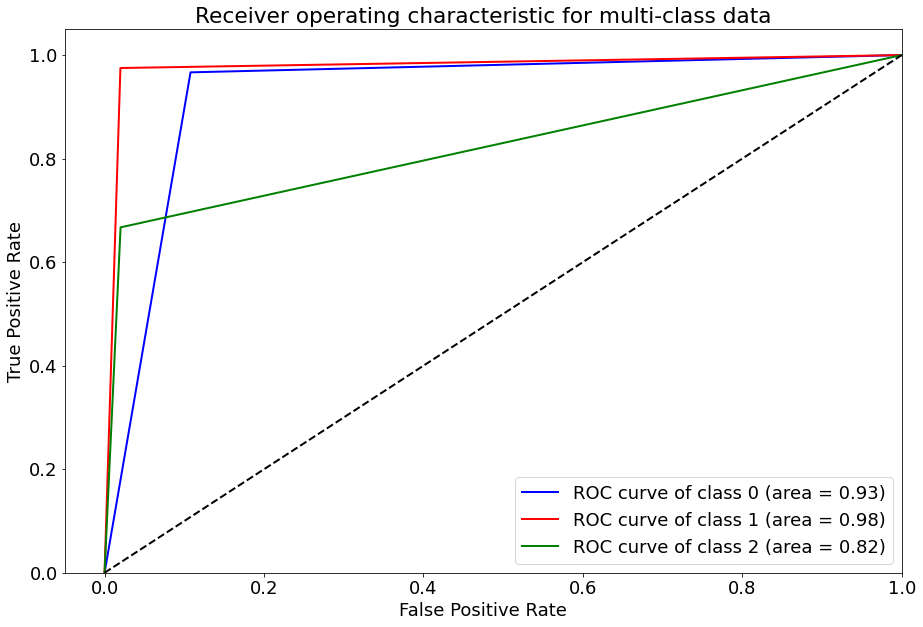

In [155]:
fpr = dict()
tpr = dict()
roc_auc = dict()
lw=2
n_classes =3
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_preds[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
colors = cycle(['blue', 'red', 'green'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))
plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic for multi-class data')
plt.legend(loc="lower right")
plt.show()

In [160]:
target_names = ['Neutral', 'Stress', 'Amusement']
print(classification_report(y_test, y_preds, target_names=target_names))

              precision    recall  f1-score   support

     Neutral       0.91      0.97      0.94      5310
      Stress       0.95      0.98      0.96      3002
   Amusement       0.87      0.67      0.76      1680

   micro avg       0.92      0.92      0.92      9992
   macro avg       0.91      0.87      0.89      9992
weighted avg       0.92      0.92      0.92      9992
 samples avg       0.92      0.92      0.92      9992



In [161]:
cm = confusion_matrix(y_test, y_preds)
cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
# sns.heatmap(cmn,annot=True, cmap='magma_r')
cmd = metrics.ConfusionMatrixDisplay(cmn, display_labels=['Neutral','Stress','Amusement'])
cmd.plot(cmap='magma_r')

# plt.xlabel('Predicted Class')
# plt.ylabel('True Class')
plt.title('Confusion Matrix')
plt.savefig('confusion_matrix.png',bbox_inches='tight', dpi=150)

ValueError: multilabel-indicator is not supported

array([[0, 1, 0],
       [1, 0, 0],
       [1, 0, 0],
       ...,
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0]])

## Differential Privacy using DP SGD Algorithm

* Change Original Fed Avg Algorithm in 2 ways.
* First Client Model Updates are clipped before transmission to server at each round, so as to minimize influence of any one client -- Use Adaptive Clipping
* Second Server must add enough noise to the sum of user updates before averaging to avoid worst case client influence. --  


In [9]:
tff.backends.native.set_local_python_execution_context(clients_per_thread=1)
rounds = 100
clients_per_round = 10
noise_multipliers = [0.0, 0.25, 0.5, 0.75]

In [ ]:
training_metrics_dp = collections.defaultdict(list)
validation_metrics_dp = collections.defaultdict(list)
test_metrics_dp = collections.defaultdict(list)
train_df = pd.DataFrame()
valid_df = pd.DataFrame()
test_df = pd.DataFrame()

NUM_ROUNDS = 100

for noise_multiplier in noise_multipliers:
    
    aggregation_factory = tff.learning.model_update_aggregator.dp_aggregator(noise_multiplier, clients_per_round)
    federated_training_dp = tff.learning.algorithms.build_unweighted_fed_avg(
            model_fn,
            client_optimizer_fn=lambda: tf.keras.optimizers.SGD(0.0001),
            server_optimizer_fn=lambda: tf.keras.optimizers.SGD(1.0, momentum=0.9),
            model_aggregator=aggregation_factory)
    
    state = federated_training_dp.initialize()
    
    print(f'Starting training with noise multiplier: {noise_multiplier}')
    for round_num in range(1,NUM_ROUNDS):
        
        participating_clients = np.random.choice(tff_dataset_train.client_ids,size=clients_per_round)
        federated_train_data = [
            preprocess_fn(tff_dataset_train.create_tf_dataset_for_client(c),train=True) for c in participating_clients
          ]

        result = federated_training_dp.next(state, federated_train_data)
        metrics = result.metrics
        state = result.state
        print('round {:2d}, metrics={}'.format(round_num, metrics))

        training_metrics_dp['loss'] = metrics.get('client_work', {}).get('train', {}).get('loss')
        training_metrics_dp['sparse_categorical_accuracy'] = metrics.get('client_work', {}).get('train', {}).get('sparse_categorical_accuracy')
        training_metrics_dp['round_num'] = round_num
        training_metrics_dp['noise_multiplier'] = noise_multiplier
    
        train_df = train_df.append(training_metrics_dp, ignore_index=True)
        
        federated_validation_dp = tff.learning.build_federated_evaluation(model_fn)

        federated_validation_data = [
            preprocess_fn(tff_dataset_valid.create_tf_dataset_for_client(c), train=False) for c in participating_clients
          ]

        model_weights = federated_training_dp.get_model_weights(state)
        eval_result = federated_validation_dp(model_weights, federated_validation_data)

        validation_metrics_dp['loss'] = eval_result.get('eval', {}).get('loss')
        validation_metrics_dp['sparse_categorical_accuracy'] = eval_result.get('eval', {}).get('sparse_categorical_accuracy')
        validation_metrics_dp['round_num'] = round_num
        validation_metrics_dp['noise_multiplier'] = noise_multiplier
        valid_df = valid_df.append(validation_metrics_dp, ignore_index=True)

        print('round {:2d}, evaluation metrics={}'.format(round_num, eval_result))
        print("\n")
        
    model_weights = federated_training_dp.get_model_weights(state)
    federated_test_data = [
            preprocess_fn(tff_dataset_test.create_tf_dataset_for_client(c), train=False) for c in tff_dataset_test.client_ids
          ]
    federated_testing_dp = tff.learning.build_federated_evaluation(model_fn)
    test_result = federated_testing_dp(model_weights,federated_test_data)
    test_metrics_dp['loss'] = test_result.get('eval', {}).get('loss')
    test_metrics_dp['sparse_categorical_accuracy'] = test_result.get('eval', {}).get('sparse_categorical_accuracy')
    test_df = test_df.append(test_metrics_dp, ignore_index=True)


Starting training with noise multiplier: 0.0
round  1, metrics=OrderedDict([('distributor', ()), ('client_work', OrderedDict([('train', OrderedDict([('sparse_categorical_accuracy', 0.26319182), ('loss', 2.1691425), ('num_examples', 32577), ('num_batches', 2041)]))])), ('aggregator', OrderedDict([('zeroing', OrderedDict([('dp_query_metrics', OrderedDict([('clip', 0.09048375)])), ('dp', ())])), ('zeroing_norm', 21.0), ('zeroed_count', 0)])), ('finalizer', ())])
round  1, evaluation metrics=OrderedDict([('eval', OrderedDict([('sparse_categorical_accuracy', 0.27204463), ('loss', 2.1594758), ('num_examples', 13983), ('num_batches', 877)]))])


round  2, metrics=OrderedDict([('distributor', ()), ('client_work', OrderedDict([('train', OrderedDict([('sparse_categorical_accuracy', 0.33425194), ('loss', 2.0069082), ('num_examples', 32658), ('num_batches', 2045)]))])), ('aggregator', OrderedDict([('zeroing', OrderedDict([('dp_query_metrics', OrderedDict([('clip', 0.08187308)])), ('dp', ())])), ('

round 14, evaluation metrics=OrderedDict([('eval', OrderedDict([('sparse_categorical_accuracy', 0.8801893), ('loss', 0.5595241), ('num_examples', 13947), ('num_batches', 874)]))])


round 15, metrics=OrderedDict([('distributor', ()), ('client_work', OrderedDict([('train', OrderedDict([('sparse_categorical_accuracy', 0.8680945), ('loss', 0.4889934), ('num_examples', 32637), ('num_batches', 2044)]))])), ('aggregator', OrderedDict([('zeroing', OrderedDict([('dp_query_metrics', OrderedDict([('clip', 0.03328711)])), ('dp', ())])), ('zeroing_norm', 11.496159), ('zeroed_count', 0)])), ('finalizer', ())])
round 15, evaluation metrics=OrderedDict([('eval', OrderedDict([('sparse_categorical_accuracy', 0.8487899), ('loss', 0.5867166), ('num_examples', 14007), ('num_batches', 879)]))])


round 16, metrics=OrderedDict([('distributor', ()), ('client_work', OrderedDict([('train', OrderedDict([('sparse_categorical_accuracy', 0.87332964), ('loss', 0.5411826), ('num_examples', 32628), ('num_batches', 20

round 28, evaluation metrics=OrderedDict([('eval', OrderedDict([('sparse_categorical_accuracy', 0.9060963), ('loss', 0.4236998), ('num_examples', 14025), ('num_batches', 879)]))])


round 29, metrics=OrderedDict([('distributor', ()), ('client_work', OrderedDict([('train', OrderedDict([('sparse_categorical_accuracy', 0.89680076), ('loss', 0.39771104), ('num_examples', 32820), ('num_batches', 2055)]))])), ('aggregator', OrderedDict([('zeroing', OrderedDict([('dp_query_metrics', OrderedDict([('clip', 0.022313021)])), ('dp', ())])), ('zeroing_norm', 6.5084677), ('zeroed_count', 0)])), ('finalizer', ())])
round 29, evaluation metrics=OrderedDict([('eval', OrderedDict([('sparse_categorical_accuracy', 0.8716202), ('loss', 0.47638702), ('num_examples', 14091), ('num_batches', 884)]))])


round 30, metrics=OrderedDict([('distributor', ()), ('client_work', OrderedDict([('train', OrderedDict([('sparse_categorical_accuracy', 0.9291601), ('loss', 0.3417728), ('num_examples', 32397), ('num_batches',

round 42, evaluation metrics=OrderedDict([('eval', OrderedDict([('sparse_categorical_accuracy', 0.90602463), ('loss', 0.36454624), ('num_examples', 14142), ('num_batches', 887)]))])


round 43, metrics=OrderedDict([('distributor', ()), ('client_work', OrderedDict([('train', OrderedDict([('sparse_categorical_accuracy', 0.9184492), ('loss', 0.34232742), ('num_examples', 32397), ('num_batches', 2030)]))])), ('aggregator', OrderedDict([('zeroing', OrderedDict([('dp_query_metrics', OrderedDict([('clip', 0.019789875)])), ('dp', ())])), ('zeroing_norm', 3.890888), ('zeroed_count', 0)])), ('finalizer', ())])
round 43, evaluation metrics=OrderedDict([('eval', OrderedDict([('sparse_categorical_accuracy', 0.9184642), ('loss', 0.3251291), ('num_examples', 13908), ('num_batches', 874)]))])


round 44, metrics=OrderedDict([('distributor', ()), ('client_work', OrderedDict([('train', OrderedDict([('sparse_categorical_accuracy', 0.92024803), ('loss', 0.32126173), ('num_examples', 32739), ('num_batches'

round 56, evaluation metrics=OrderedDict([('eval', OrderedDict([('sparse_categorical_accuracy', 0.9267094), ('loss', 0.29239655), ('num_examples', 14040), ('num_batches', 880)]))])


round 57, metrics=OrderedDict([('distributor', ()), ('client_work', OrderedDict([('train', OrderedDict([('sparse_categorical_accuracy', 0.9145868), ('loss', 0.38169974), ('num_examples', 32454), ('num_batches', 2033)]))])), ('aggregator', OrderedDict([('zeroing', OrderedDict([('dp_query_metrics', OrderedDict([('clip', 0.019013906)])), ('dp', ())])), ('zeroing_norm', 2.517161), ('zeroed_count', 0)])), ('finalizer', ())])
round 57, evaluation metrics=OrderedDict([('eval', OrderedDict([('sparse_categorical_accuracy', 0.9110872), ('loss', 0.3959535), ('num_examples', 13935), ('num_batches', 875)]))])


round 58, metrics=OrderedDict([('distributor', ()), ('client_work', OrderedDict([('train', OrderedDict([('sparse_categorical_accuracy', 0.94013333), ('loss', 0.2383439), ('num_examples', 32706), ('num_batches', 

round 70, evaluation metrics=OrderedDict([('eval', OrderedDict([('sparse_categorical_accuracy', 0.9193792), ('loss', 0.3106527), ('num_examples', 13917), ('num_batches', 874)]))])


round 71, metrics=OrderedDict([('distributor', ()), ('client_work', OrderedDict([('train', OrderedDict([('sparse_categorical_accuracy', 0.9126604), ('loss', 0.29167396), ('num_examples', 32574), ('num_batches', 2041)]))])), ('aggregator', OrderedDict([('zeroing', OrderedDict([('dp_query_metrics', OrderedDict([('clip', 0.01978988)])), ('dp', ())])), ('zeroing_norm', 1.7962182), ('zeroed_count', 0)])), ('finalizer', ())])
round 71, evaluation metrics=OrderedDict([('eval', OrderedDict([('sparse_categorical_accuracy', 0.90085834), ('loss', 0.34507486), ('num_examples', 13980), ('num_batches', 877)]))])


round 72, metrics=OrderedDict([('distributor', ()), ('client_work', OrderedDict([('train', OrderedDict([('sparse_categorical_accuracy', 0.89638597), ('loss', 0.42497146), ('num_examples', 32457), ('num_batches'

round 84, evaluation metrics=OrderedDict([('eval', OrderedDict([('sparse_categorical_accuracy', 0.8945687), ('loss', 0.39594668), ('num_examples', 14085), ('num_batches', 884)]))])


round 85, metrics=OrderedDict([('distributor', ()), ('client_work', OrderedDict([('train', OrderedDict([('sparse_categorical_accuracy', 0.9287099), ('loss', 0.31766438), ('num_examples', 32487), ('num_batches', 2035)]))])), ('aggregator', OrderedDict([('zeroing', OrderedDict([('dp_query_metrics', OrderedDict([('clip', 0.01978988)])), ('dp', ())])), ('zeroing_norm', 1.4178617), ('zeroed_count', 0)])), ('finalizer', ())])
round 85, evaluation metrics=OrderedDict([('eval', OrderedDict([('sparse_categorical_accuracy', 0.91672045), ('loss', 0.33660704), ('num_examples', 13941), ('num_batches', 877)]))])


round 86, metrics=OrderedDict([('distributor', ()), ('client_work', OrderedDict([('train', OrderedDict([('sparse_categorical_accuracy', 0.9302467), ('loss', 0.30468854), ('num_examples', 32916), ('num_batches'

2022-07-10 06:56:33.517165: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


round 94, evaluation metrics=OrderedDict([('eval', OrderedDict([('sparse_categorical_accuracy', 0.90856034), ('loss', 0.3383895), ('num_examples', 13878), ('num_batches', 870)]))])


round 95, metrics=OrderedDict([('distributor', ()), ('client_work', OrderedDict([('train', OrderedDict([('sparse_categorical_accuracy', 0.9406925), ('loss', 0.31474003), ('num_examples', 32694), ('num_batches', 2048)]))])), ('aggregator', OrderedDict([('zeroing', OrderedDict([('dp_query_metrics', OrderedDict([('clip', 0.018268362)])), ('dp', ())])), ('zeroing_norm', 1.263653), ('zeroed_count', 0)])), ('finalizer', ())])
round 95, evaluation metrics=OrderedDict([('eval', OrderedDict([('sparse_categorical_accuracy', 0.93567), ('loss', 0.3313846), ('num_examples', 14037), ('num_batches', 880)]))])


round 96, metrics=OrderedDict([('distributor', ()), ('client_work', OrderedDict([('train', OrderedDict([('sparse_categorical_accuracy', 0.9156235), ('loss', 0.29303655), ('num_examples', 32592), ('num_batches', 20

round  9, evaluation metrics=OrderedDict([('eval', OrderedDict([('sparse_categorical_accuracy', 0.7570332), ('loss', 1.0528141), ('num_examples', 14076), ('num_batches', 884)]))])


round 10, metrics=OrderedDict([('distributor', ()), ('client_work', OrderedDict([('train', OrderedDict([('sparse_categorical_accuracy', 0.74822336), ('loss', 1.0507724), ('num_examples', 32787), ('num_batches', 2054)]))])), ('aggregator', OrderedDict([('zeroing', OrderedDict([('dp_query_metrics', OrderedDict([('clip', 0.044575397)])), ('dp', ())])), ('zeroing_norm', 14.213877), ('zeroed_count', 0)])), ('finalizer', ())])
round 10, evaluation metrics=OrderedDict([('eval', OrderedDict([('sparse_categorical_accuracy', 0.76028126), ('loss', 0.98823345), ('num_examples', 14079), ('num_batches', 883)]))])


round 11, metrics=OrderedDict([('distributor', ()), ('client_work', OrderedDict([('train', OrderedDict([('sparse_categorical_accuracy', 0.82719123), ('loss', 0.8439188), ('num_examples', 32562), ('num_batches'

round 23, evaluation metrics=OrderedDict([('eval', OrderedDict([('sparse_categorical_accuracy', 0.9023446), ('loss', 0.48931265), ('num_examples', 13947), ('num_batches', 874)]))])


round 24, metrics=OrderedDict([('distributor', ()), ('client_work', OrderedDict([('train', OrderedDict([('sparse_categorical_accuracy', 0.8904639), ('loss', 0.48588574), ('num_examples', 32592), ('num_batches', 2041)]))])), ('aggregator', OrderedDict([('zeroing', OrderedDict([('dp_query_metrics', OrderedDict([('clip', 0.024458455)])), ('dp', ())])), ('zeroing_norm', 7.9347477), ('zeroed_count', 0)])), ('finalizer', ())])
round 24, evaluation metrics=OrderedDict([('eval', OrderedDict([('sparse_categorical_accuracy', 0.88572043), ('loss', 0.52858317), ('num_examples', 13992), ('num_batches', 879)]))])


round 25, metrics=OrderedDict([('distributor', ()), ('client_work', OrderedDict([('train', OrderedDict([('sparse_categorical_accuracy', 0.8634125), ('loss', 0.7180138), ('num_examples', 32082), ('num_batches'

round 37, evaluation metrics=OrderedDict([('eval', OrderedDict([('sparse_categorical_accuracy', 0.9003229), ('loss', 0.3989103), ('num_examples', 13935), ('num_batches', 874)]))])


round 38, metrics=OrderedDict([('distributor', ()), ('client_work', OrderedDict([('train', OrderedDict([('sparse_categorical_accuracy', 0.8884385), ('loss', 0.38758144), ('num_examples', 32565), ('num_batches', 2040)]))])), ('aggregator', OrderedDict([('zeroing', OrderedDict([('dp_query_metrics', OrderedDict([('clip', 0.020540481)])), ('dp', ())])), ('zeroing_norm', 4.639411), ('zeroed_count', 0)])), ('finalizer', ())])
round 38, evaluation metrics=OrderedDict([('eval', OrderedDict([('sparse_categorical_accuracy', 0.8787554), ('loss', 0.43738785), ('num_examples', 13980), ('num_batches', 878)]))])


round 39, metrics=OrderedDict([('distributor', ()), ('client_work', OrderedDict([('train', OrderedDict([('sparse_categorical_accuracy', 0.9143997), ('loss', 0.31148067), ('num_examples', 33084), ('num_batches', 

In [42]:
# model_weights = federated_training_dp.get_model_weights(state)
train_df

,loss,noise_multiplier,round_num,sparse_categorical_accuracy
0,2.673131,0.00,1.0,0.159648
1,2.544139,0.00,2.0,0.183136
2,2.513400,0.00,3.0,0.179492
3,2.109029,0.00,4.0,0.255206
4,1.926182,0.00,5.0,0.316471
...,...,...,...,...
391,0.648061,0.75,95.0,0.881776
392,0.630189,0.75,96.0,0.899319
393,0.402892,0.75,97.0,0.922812
394,0.352472,0.75,98.0,0.916813


<AxesSubplot:xlabel='round_num', ylabel='sparse_categorical_accuracy'>

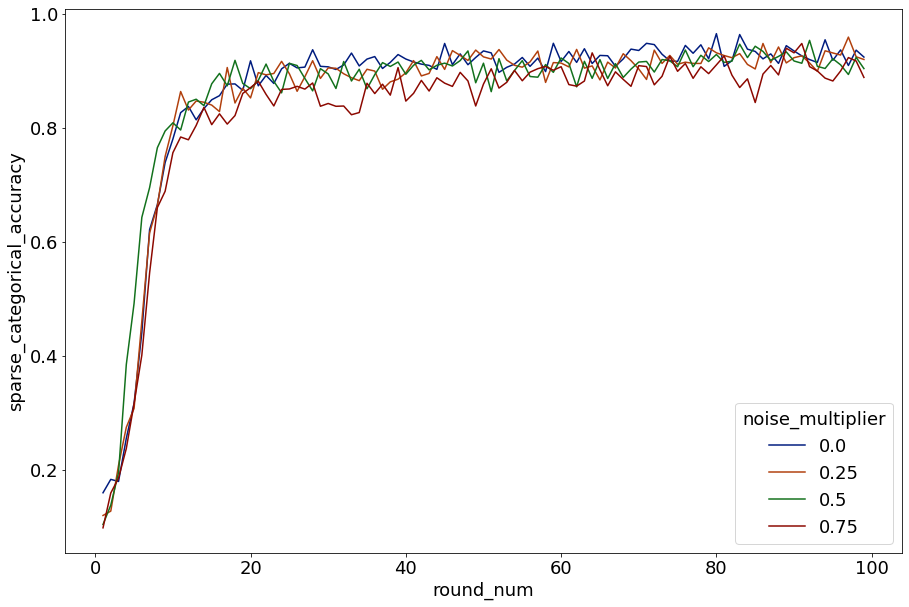

In [43]:
sns.lineplot(data=train_df, x='round_num', y='sparse_categorical_accuracy', hue='noise_multiplier', palette='dark')

<AxesSubplot:xlabel='round_num', ylabel='loss'>

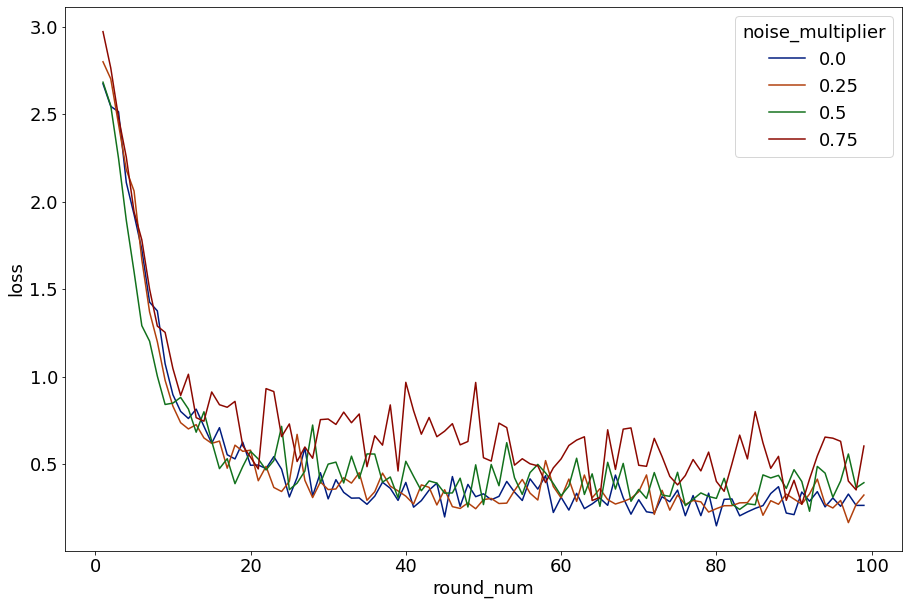

In [44]:
sns.lineplot(data=train_df, x='round_num', y='loss', hue='noise_multiplier', palette='dark')

<AxesSubplot:xlabel='round_num', ylabel='loss'>

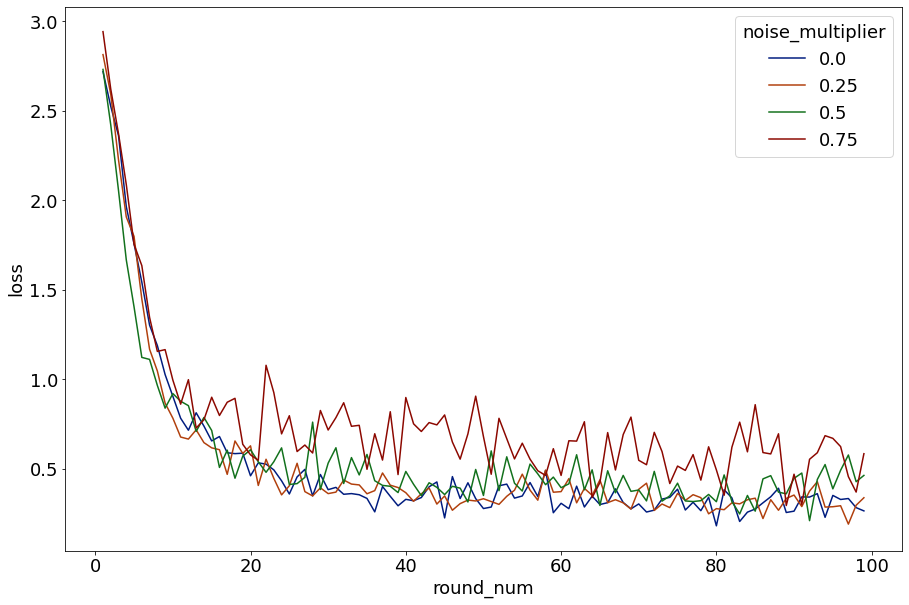

In [45]:
sns.lineplot(data=valid_df, x='round_num', y='loss', hue='noise_multiplier', palette='dark')

<AxesSubplot:xlabel='round_num', ylabel='sparse_categorical_accuracy'>

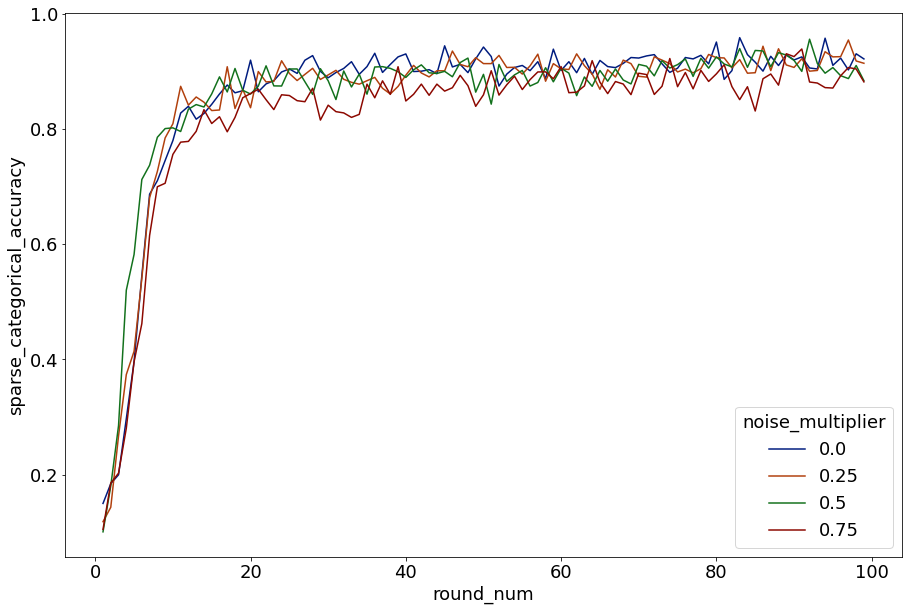

In [46]:
sns.lineplot(data=valid_df, x='round_num', y='sparse_categorical_accuracy', hue='noise_multiplier', palette='dark')

In [ ]:
model_weights = federated_training_dp.get_model_weights(state)
federated_testing_dp(model_weights, federated_test_data)

In [ ]:
keras_model = create_keras_model()
state.model.ass